# Настройки обучения нейронных сетей в `PyTorch`

<!-- [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1k5ih-FSbCTuErwBHHi3J3uCN1q4fRzFI) -->

## Импорт `torch`

In [36]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchinfo import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Настроим работу с `PyTorch`. Выбирем формат работы и устройство для работы.

In [37]:
def torch_stats(): 
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32
    
    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)
        
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')


    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)
    
    num_workers=os.cpu_count()
    print ('available number of workers:',num_workers)
    
    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn    
    


In [38]:
device, dtype, num_workers = torch_stats()
torch_seed(seed = 42, deterministic = True)

torch version: 2.1
Using device: cpu
default data type: torch.float32
available number of workers: 4


## Набор данных

Рассмотрим набор данных FashionMNIST, который в этот раз импортируется из пакета `torchvision.datasets`

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [40]:
transform_ = lambda x: x.flatten() / 255.0
transform=transforms.Compose([
                           transforms.ToTensor(),
                           transform_,
                            ])

При загрузке набора данных задаются стандартные преобразования `transforms`. Тренировочная часть и тестовая часть загружаются отдельно.

In [41]:
# import ssl

# ssl._create_default_https_context = ssl._create_stdlib_context

In [42]:
train_data = datasets.FashionMNIST('data', train=True,  download=True,  transform=transform)
test_data  = datasets.FashionMNIST('data', train=False, download=True, transform=transform)

Полученный набор данных представляет собой итерируемый объект. Доступ к отдельным элементам такого датасета может быть получен как для списка. Каждый элемент представляет собой изображение (в нашем случае — вектор) и его метку.

In [43]:
train_data[0][0].shape, train_data[0][1] 

(torch.Size([784]), 9)

In [44]:
name_classes = ['T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

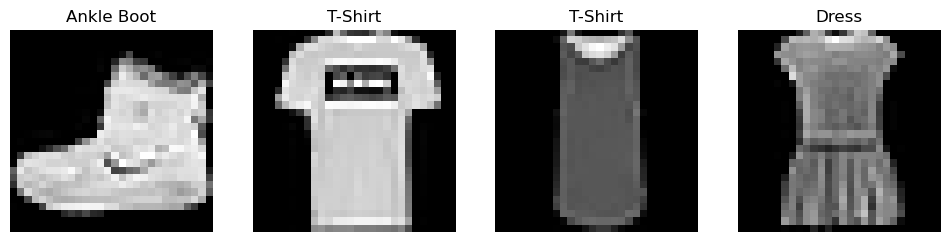

In [45]:
WIDTH = 28
HEIGH = 28
fig, axs = plt.subplots(1,4,figsize=(12,3));
axs[0].imshow(train_data[0][0].view(WIDTH,HEIGH), cmap='gray'); axs[0].set_title(name_classes[train_data[0][1]]); axs[0].axis('off')
axs[1].imshow(train_data[1][0].view(WIDTH,HEIGH), cmap='gray'); axs[1].set_title(name_classes[train_data[1][1]]); axs[1].axis('off')
axs[2].imshow(train_data[2][0].view(WIDTH,HEIGH), cmap='gray'); axs[2].set_title(name_classes[train_data[2][1]]); axs[2].axis('off')
axs[3].imshow(train_data[3][0].view(WIDTH,HEIGH), cmap='gray'); axs[3].set_title(name_classes[train_data[3][1]]); axs[3].axis('off')
plt.show()

Соотвественно можно узнать размер выборок

In [46]:
len(train_data), len(test_data)

(60000, 10000)

После загрузки изображений в формате `pytorch` необходимо автоматизировать генерацию пакетов, по которым будет производиться обучение, то есть батчей. Желательно производить загрузку батчей динамически/стохастически. Другими словами, во время каждой эпохи обучения мы будем вызывать от необходимое количество таких батчей, каждый из которых будет представлять собой заданное количество примеров входных данных, выбранных случайно из последовательности.

Для осуществления указанного кода воспользуемся утилитой `DataLoader` из `torch.utils.data`. Пример реализации показан ниже

Набор данных MNIST поставляется с обучающим и тестовым набором, но без валидационного набора. Однако, использование валидационного набора кажется крайне желательным, например, чтобы проверить, насколько хорошо  модель работает на более не менее независимых данных (по крайней мере на данных, чьи случайные изменения модель не видет в тренировочной выборке). <br>
Остется понять, почему бы нам просто не использовать тестовые данные? Тестовый набор данных позволяет произвести замер производительности только один раз - после завершения обучения. Тестовый набор покажет действительную обобщающую способоность модели. Тестовый набор должен быть максимально независим от тренировочных данных. Валидационной набор данных можно рассматривать  как косвенное тесирование модели на данных, похожих на тренировочные. Поэтому часто валидационные данные выбирают из тренировочных. Например выбирают случайно.  <br>
Выбирием валидционные набор данных как 20% от трениоровочных.<br>
>**Примечание:** валидационный набор всегда должен создаваться из обучающего набора. Никогда не берите валидационный набор из тестового набора. Когда исследователи публикуют научные работы, они должны сравнивать производительность по тестовому набору, и единственный способ обеспечить справедливое сравнение - использовать один и тот же тестовый набор для всех исследователей. Если валдиационный набор берется из тестового, то тестовый набор не такой, как у всех, и результаты нельзя сравнивать друг с другом. 
 
Для выделения валидационного набора используем утилиту `random_split` из `torch.utils.data`.

<blockquote> 
Отметим что могут быть и другие способы сплита даннх
    
```python
    from torch.utils.data import SubsetRandomSampler
    indices=np.arange(len(train))
    np.random.shuffle(indices)
    
    split=int(np.floor(valid_size*len(train)))
    train_idx = indices[split:]
    valid_idx = indices[:split]
    
    train_sampler=SubsetRandomSampler(train_idx)
    valid_sampler=SubsetRandomSampler(valid_idx)
    
    
    train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size,  
                                             sampler=train_sampler, num_workers=num_workers)
    valid_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size,  
                                             sampler=train_sampler, shuffle=False, num_workers=num_workers)
    test_loader =torch.utils.data.DataLoader(test_data,  batch_size=batch_size, 
                                             shuffle=False,  num_workers=num_workers)

```

</blockquote>

In [47]:
VALID_RATIO = 0.8

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])

print(f"Training data size : {len(train_data)}, Validation data size : {len(valid_data)}, Test data size : {len(test_data)}")

Training data size : 48000, Validation data size : 12000, Test data size : 10000


Теперь получены три набора данных: валидационный, тренировочный и тестовый. <br>
__Важно__ также отметить, что если тренировочные данные используются с аугментацией, то валидационный набор данных лучше использовать без аугментации. Ниже показан пример того как это можно сделать.

```python
    valid_data = copy.deepcopy(valid_data)
    valid_data.dataset.transform = test_transforms
```




Теперь создадим загрузчики данных. 

>Важно отметить, что загрузка набора данных и загрузчик данных является одтдельными по важности составляющими обучени нейронных сетей.

In [48]:
BATCH_SIZE = 64

train_loader = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

val_loader = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_loader = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

 
print(f"Training data batches : {len(train_loader)}, Validation data batches : {len(val_loader)}, Test data batches : {len(test_loader)}")

Training data batches : 750, Validation data batches : 188, Test data batches : 157


Проверим размер каждого батча

In [49]:
images, _ =  next(iter(train_loader))
images.shape

torch.Size([64, 784])

Проведем визуализацию батча. Для этого в `torchvision` предусмотрена специальная функция `make_grid`.
<!-- 
Обратите внимание на порядок операций в примере с визуализацией. Сначала производится преобразование размеров батча. Из размеров $[64, 784]$, означающих $64$ вектора, каждый по $784$ значения, мы получаем 64 изображения, каждое размером $28\times 28$.\
Однако также мы добавляем дополнительную пустую размерность. То есть вместо того, чтобы получить массив $[64, 28, 28]$, мы получаем размер $[64, 1, 28, 28]$. Дополнительная размерность означает канал изображения. В нашем случае канал только $1$. Однако в более продвинутых задачах анализа изображений мы будем использовать и по $3$ канала.\
Аналогично, и в нашем случае для визуализации батч будет создан с $3$ каналами. Поскольку мы формируем изображение, где по горизонтали должно уместиться 8 изображений, то размер будет $[3, 28\cdot 8, 28\cdot 8] = [3, 224, 224]$.

Также важно отметить, что после получения батча мы проводим операцию `transpose((1, 2, 0))` — то есть каналы становятся `3`-й размерностью, а не `1`-й. Тут имеет место крайне важное различие между представлением данных в `matplotlib` и `torch`. В `matplotlib` каналы — это последняя размерность. Тогда как в `torch` каналы — это или `1`-я размерность, или `2`-я, если речь идет о наборе изображений (батче). -->

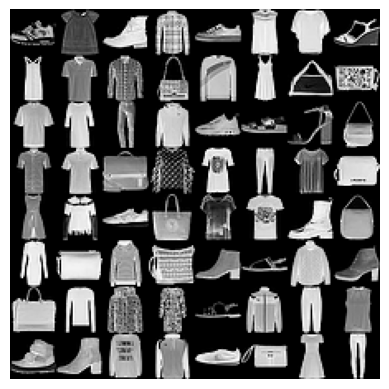

(torch.Size([64, 1, 28, 28]), torch.Size([3, 224, 224]), (224, 224, 3))

In [50]:
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape


# Начнем с уже изученной полносвязной архитекутры

In [51]:
IMAGE_WIDTH = 28 
IMAGE_HEIGH = 28

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x  #log(softmax(x)) in loss assumed

Также важно уточнить, что в указанных структурах могут быть заданы не только полные модели, но и их [отдельные слои](https://github.com/Devinterview-io/pytorch-interview-questions?tab=readme-ov-file#process-for-implementing-custom-layers).

Проверим результат

In [52]:
model = Model()

summary(model,input_size =(1,784))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Linear: 1-1                            [1, 64]                   50,240
├─Linear: 1-2                            [1, 64]                   4,160
├─Linear: 1-3                            [1, 10]                   650
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.22

Как и прежде используем алгоритм `Adam` с параметрами по умолчанию для обновления нашей модели. Улучшенные результаты можно получить, перебирая различные оптимизаторы и скорости обучения, однако стандартный `Adam` обычно является хорошей отправной точкой. 

In [53]:
optimizer = optim.Adam(model.parameters())

Аналогично предыдущим занятиям зададимся функцией потерь `CrossEntropyLoss`

In [54]:
criterion = nn.CrossEntropyLoss() #This criterion assume built-in `log_softmax` 

Отметим, что на самом деле, если используется `GPU` в качестве вычислителя, то следует отправить и функцию потерь и модель на устройство.

In [55]:
model = model.to(device)
criterion = criterion.to(device)

> Если для обучения моделей используют несколько GPU, то самым простым подходом в этой ситуации будет применение класса `DistributedDataParallel` (`DDP`). В результате будут созданы несколько идентичных процессов, а градиенты будут агрегироваться на шаге обратного прохода. <br>
> Также [может быть использован](https://habr.com/ru/companies/wunderfund/articles/820721/) `Fully Sharded Data Parallel` (`FSDP`, параллелизм с полным шардингом данных). В этом режиме данные асинхронно распределяются между `GPU` вместо того чтобы запускать код на каждом `GPU` с одинаковыми моделями и с одинаковыми состояниями оптимизатора.
> `from torch.distributed.fsdp import FullyShardedDataParallel as FSDP` и `model = FSDP(model)`

Также напомним что в версии `PyTorch 2.x` доступен способ ускорения модели при помощи ее компиляции [`torch.compile`](https://pytorch.org/docs/stable/generated/torch.compile.html). [В этом режиме](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) вычислительный граф модели собирается при первом проходе по ней вместо того, чтобы вычисляться динамический каждый раз.

Отметим, то на сегодня `torch.compile` работает не на всех платформах.

In [56]:
from sys import platform
if platform == "linux" or platform == "linux2":
    model = torch.compile(model)

Также создадим отдельную функцию для расчета точности модели.

In [57]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

metric = calculate_accuracy

Перед началом тренировки запишем функцию `train`, которая должна реализовывать тренировку в рамках 1 эпохи. 

Функция будет выбирать все батчи из dataloader в формате `x` - данные и `y` - ответы. Затем для каждого батча будет производится расчет выхода модели `model.forward(x)` и расчет параметров `loss` (потери) и `acc` (точность). 

Функция имеет следующую последовательность действий:
- перевод модели в режим `обучения` (`model.train()`).
- перебор загрузчика данных, возвращая `batch`  
- размещение данных на `GPU`, если есть
- очистка градиент `zero_grad(set_to_none = True)`
- передача пакета изображений, `x`, в модель, чтобы получить предсказания, `y_pred`.
- вычисление функции потерь между предсказаниями и фактическими метками
- вычисление точности между предсказаниями и реальными метками
- вычисление градиенты каждого параметра
- обновление параметров, выполнив шаг оптимизатора
- обновление метрики

*Отметим* 
* В режиме тренировки модель должна иметь директиву train  `model.train()`, которая необходима в ряде элементов (например batchnorm), имеющих разное поведения при тренировке и эксплуотации.

* Также отметим, что `dataloader` вызывается при помощи `tqdm` - то есть т.н. *progress bar*.

In [58]:
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Аналогично создадим функцию `evaluate`, которая позволяет оценивать работу модели, например, для валидационного или тестового наборов данных. Особенностями этой функции будут деректива `model.eval()` и `torch.inference_mode()`, которые необходимы в режиме тестирования нейронной сети.
<!-- 
`torch.no_grad()` гарантирует, что градиенты не будут вычисляться для всего, что находится внутри блока `with`. Поскольку нашей модели не придется вычислять градиенты, она будет работать быстрее и использовать меньше памяти.  -->

In [59]:
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.inference_mode():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Запишем вспомогательную функцию расчета времени.

In [60]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Итоговый процесс обучения будут состоять из процедур тренировки и оценки для каждой эпохи. Также будет оцениваться время работы каждой эпохи.

В процедуру включена проверка модели на лучшее значение метрики на валидации. Лучшая метрика сохраняется. Точнее сохраняются ее параметры `model.state_dict()`

In [61]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')


  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 1.320 | Train Acc: 50.74%  | Val. Loss: 0.869 | Val. Acc: 66.66%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 10s
	Train Loss: 0.773 | Train Acc: 70.46%  | Val. Loss: 0.715 | Val. Acc: 72.98%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 10s
	Train Loss: 0.663 | Train Acc: 75.26%  | Val. Loss: 0.644 | Val. Acc: 76.49%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 10s
	Train Loss: 0.609 | Train Acc: 77.80%  | Val. Loss: 0.605 | Val. Acc: 78.41%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.579 | Train Acc: 79.17%  | Val. Loss: 0.575 | Val. Acc: 79.67%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 10s
	Train Loss: 0.557 | Train Acc: 80.09%  | Val. Loss: 0.557 | Val. Acc: 80.49%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.541 | Train Acc: 80.68%  | Val. Loss: 0.544 | Val. Acc: 80.93%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.526 | Train Acc: 81.27%  | Val. Loss: 0.528 | Val. Acc: 81.50%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.514 | Train Acc: 81.77%  | Val. Loss: 0.519 | Val. Acc: 81.91%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 10s
	Train Loss: 0.502 | Train Acc: 82.22%  | Val. Loss: 0.519 | Val. Acc: 81.71%


Теперь вместо того, чтобы останавливаться на последней эпохе выбирем лучшую эпоху и загрузим ее значения. 

Проверим точность модели на тестовых данных

In [62]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.537 | Test Acc: 81.16%


Отметим, что в общем случае есть несколько опций [сохранения моделей](https://pytorch.org/tutorials/beginner/saving_loading_models.html). 
* Сохранение всей модели с помощью функции `torch.save()` и передача всей модели.
* Сохранение только обучаемых параметров и весов модели путем сохранения `state_dict` модели. `State_dict` - это объект словаря `Python`, который содержит обучаемые параметры модели (например, веса и смещения) и другую информацию, необходимую для восстановления архитектуры и параметров модели.

Зачастую `state_dict` имеет меньший размер файла, и это делает загрузку модели более интуитивной, так как не требует явной загрузки архитектуры модели. Модель загружается отдельно. Однако,  сохранение всей модели позволяет сохранить весь объект, включая архитектуру модели, параметры и любую другую связанную информацию (например, состояние оптимизатора). При этом все состояние модели сохраняется как единый объект в файл формата `pickle`.

Ниже приведен пример сохранения полной модели.

In [63]:
torch.save(model, 'file_path.p')

In [64]:
model = torch.load('file_path.p')
model.eval()

Model(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Сохраненные модели можно запускть в других форматах, например в релиз можно запускать модели в более быстром [формате](https://pytorch.org/docs/stable/jit.html)  [`TorchScript`](https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html) (формат использует  [`C++`  компилятор](https://pytorch.org/tutorials/advanced/cpp_export.html)).

In [65]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save
model = torch.jit.load('model_scripted.pt')
model.eval()

RecursiveScriptModule(
  original_name=Model
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)

[Также возможено сохранение всего чекпоинта](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-a-general-checkpoint-for-inference-and-or-resuming-training) при обучении модели (не только стостояния модели, но и параметров обучения, например
```python
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            ...
            }, PATH)
```

## Задание

__1.__ Предлагается дополнить процедуру обучения сохранением истории изменения метрики и лосса на трейне и валидации в виде скользящего среднего и СКО.

__2.__ Выбор размера батча `batch_size` - важный элемент в обучении любой модели. Это связано с несколькими вещами. 
* Во-первых чем больше батч, тем в среднем лучше обобщающая способность модели. Однако, чем меньше батч - тем выше точность на тренировочных данных (без учета обобщяющей способности и вопроса переобучения). 
* Во-вторых [правильный выбор размера батча](https://habr.com/ru/companies/wunderfund/articles/816657/) позволяет достигнать оптимальной производительности модели на этапе обучения (да и работы) модели. Это связано с т.н. эффектом латентности - времени загрузки данных на вычислитель. А также это связано с объемом памяти вычислителя. 
* В-третьих чем больше размер батча, тем менее жесткие требования к выбору гиперпараметров модели и [тем больше в целом может быть выбрана скорость обучения](https://www.baeldung.com/cs/learning-rate-batch-size) (то есть обучение будет быстрее, усреднеие разброса параметров по батчам будет меьше).

Поэтому в ряде случаев рекомендуется проводить процедуру обратного распростронения ошибки не по одному батчу - а по нескольким. То есть копить градиент `forward propagation` нескольких батчей прежде чем запустить (один раз) `backward propagation`. Таким образом создается эффект "виртуально" большей памяти вычислителя (напр. `GPU`). 

Предалается реализовать этот подход самостоятельно.


__3.__ Предлагается дополнить процесс обучения процедурой `early stop` по 3-м эпохам обучения и условию что метрика на валидации не меняется более чем на $5\%$ по скользящему среднему.

__4.__ Использование сохранений `state_dict` позволяет запускать обучение новых моделей в режиме `warm start` - то есть с начальными значениями параметров, проинциализированными результатами предыдущего обучения.  Так новой модели будет легче обучиться. Например это будет актуальным, если вы обучили моделиь, запустили ее в релиз, затем сорбали новые данные и готовы заново обучить модель. Или если вы взяли готовую модель из стандартных библиотек (предобученную модель). Тогда  `warm start` упростит процесс обучения и позволит добиться большей точности, особенно в случае небольшого тренировочного набора данных. 

Позже эта тема будет рассмотренна более подробно. 

Тут __предлагается__ обучающемуся создать новую модель, например, имеющего на один слой больше предыдущей модели,  загрузить в нее предобученные весовые параметры и запусть новый процесс обучения, например поменяв оптимизатор. Таким образом мы как-бы симулируем новизну эксперимента. 

> Новый слой должен иметь новое название, не совпадающее с объявленными ранее слоями.

>Независимо от того, загружаете ли вы параметры из частичного `state_dict`, в котором отсутствуют некоторые ключи, или загружаете `state_dict` с большим количеством ключей, чем в модели, в которую вы загружаете параметры, вы можете установить аргумент `strict` в значение `False` в функции `load_state_dict()`, чтобы игнорировать несовпадающие ключи.

>Если вы хотите загрузить параметры из одного слоя в другой, но некоторые ключи не совпадают, просто измените имена ключей параметров в загружаемом `state_dict`, чтобы они совпадали с ключами в модели, в которую вы загружаете.

__5.__ Проведите анализ ошибок модели самостоятельно.

__6.__ Предлагается дополнить процедуру обучения более единообразным логированием результатов. Например при помощи словаря. Пример словаря показан ниже.
```python
        results = {"train_loss": [],
                   "train_acc":  [],
                   "test_loss":  [],
                   "test_acc":   []}
```

```python
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
```

# Приемы обучения НС

## Инициализация обучения

Для повышения качества работы с моделями проведем инициализацию весовых параметров при помощи модуля [`nn.init`](https://pytorch.org/docs/stable/nn.init.html).

> Отмеимт, что в ряде случаев достаточно инициализации "по умолчанию". В других случаях лучше проводить рекомендованные схемы инициализации. Однако, пробуя вручную различные схемы инициализации, мы обычно можем добиться небольшого улучшения производительности.

Инициализируем параметры создавая функцию, которая принимает модуль (слой) модели, проверяет, какого типа этот слой, а затем использует методы `nn.init` для инициализации параметров рекомендуемым способом.

В достаточно общем случае можно сказать что инициализация имеет вид нормального или равномерного распределений с парамтером ( стандартным отклонением или разбросом), заданным:

$$\frac{\text{gain}}{\sqrt{\text{fan mode}}}$$

Значение $\text{gain}$ зависит от нелинейности, которая  будет использована после  слоя. Например `ReLU` устанавливает $\text{gain}$ в $\sqrt{2}$. Значение $\text{fan mode}$ может быть либо `fan_in`, либо `fan_out`. `fan_in` - это количество соединений, входящих в слой, а `fan_out` - количество соединений, выходящих из слоя. Количество соеденений - это количество параметров (оно есть не только у полносвязного слоя, но и у остальных слоев). Для линейного слоя можно записать названную инициалиазцию как $$\frac{\text{2}}{\sqrt{\text{fan in}+\text{fan out}}}$$     
>  Например для сверточного слоя на вход поступает фильтр 3x3x3, поэтому `fan_in` равно 27, а на выход - 64x3x3, поэтому `fan_out` равно 576.  Эта схема инициализации называется *Kaiming Normal*, также известная как *Xe Normal*.

В `nn.init` есть функция `calculate_gain`, которая рассчитывает $\text{gain}$  для заданных функций активации.

При инициплизции - инициализируем члены смещения нулями.

> Зачем  вообще нужно инициализировать параметры? Мы хотим, чтобы выходы каждой функции активации (и, следовательно, входы последующего слоя) имели среднее значение 0 и стандартное отклонение 1.  Тогда выход производной функций активации будет максимальным, а значения весов не приведет к вымыванию или взрыву градиента

Подробней о рекомендациях инициализации смотрите [в документации](https://pytorch.org/docs/stable/nn.init.html).

In [66]:
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

Применим инициализацию с помощью метода модели `apply`. Это вызовет заданную функцию на каждом модуле и подмодуле в модели. Отметим

In [67]:
model.apply(initialize_parameters)

RecursiveScriptModule(
  original_name=Model
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
)

## Поиск диапазона скоростей обучения

Проведем поиск оптимальной скорости обучения. 
Для этого используем готовую утилиту [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder). 
<!-- Код здесь взят из урезанной и слегка модифицированной версии  [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder).
```python
from torch.optim.lr_scheduler import _LRScheduler

class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr=10, num_iter=100,
                   smooth_f=0.05, diverge_th=5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            lrs.append(lr_scheduler.get_last_lr()[0])

            # update lr
            lr_scheduler.step()

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        # reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()


class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r
                for base_lr in self.base_lrs]


class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

def plot_lr_finder(lrs, losses, skip_start=5, skip_end=5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

    best_lr = lrs[np.argmin(losses)]

    print(f'Best lr = {best_lr:.5f}')

    return best_lr

best_lr = plot_lr_finder(lrs, losses)
``` -->

>**Примечание**: поиск скорости обучения - это скорее искусство, чем наука. Алгоритм не сможет найти точную скорость обучения с точностью до $5$ знаков после запятой, которая всегда будет давать нам $100\%$ точность - но обычно это будет лучше, чем просто выбрать скорость обучения из воздуха.  

>Наиболее часто используемый оптимизатор - `Adam`. Скорость обучения `Adam` по умолчанию обычно является отличным выбором, но, подобно тому, как  вручную инициализировали параметры, чтобы потенциально получить некоторое улучшение производительности, мы можем попытаться рассчитать оптимальную скорость обучения вручную.

Как работает система поиска скорости обучения? В алгоритм `finder` подается модель, оптимизатор и критерий, который хотелось бы использовать. Оптимизатору задается скорость обучения с гораздо меньше, чем предполагается использовать. Затем обучаются модели на данных из обучающего набора - вычисляются потери и обновляются параметры. После каждой партии экспоненциально увеличивается скорость обучения. Так делается вплоть до заданного верхнего предела.  Это повторяется до тех пор, пока значения функции потерь не начинают расходятся более чем в 5 раз по сравнению с наилучшими потерями или пока не достигнута максимальная скорость обучения. 

Вычисленные функции потерь обычно довольно шумные, поэтому сохраняется экспоненциальное среднее значений по батчам. 

>При настоящем обучении необходимо использовать инициализированные параметры, а не те, которые были обновлены в результате поиска скорости обучения. Поэтому сохраним параметры модели на диск при инициализации алгоритма поиска, а затем сбрасим их на желаемые инициализированные параметры непосредственно перед возвратом функции `range_test`, загружая начальные значения с диска.

Сначала сдается экземпляр класса `finder` с моделью, оптимизатором и  функцией потерь. Затем мы используется `range_test` с обучающим итератором, максимальной скоростью обучения и количеством итераций, которые мы хотим использовать. 

In [68]:
# !pip3 install torch_lr_finder
from torch_lr_finder import LRFinder

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.18E-01


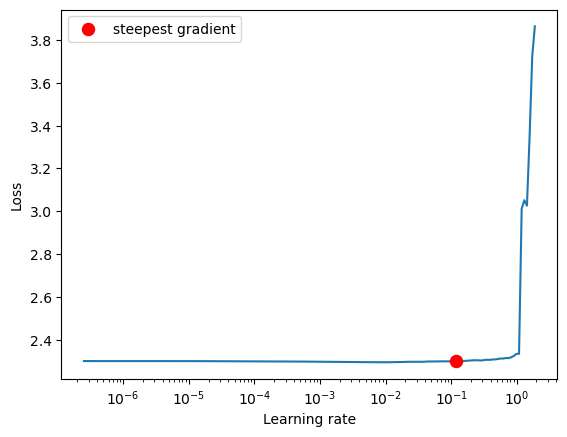

In [69]:
START_LR = 1e-7
model = Model()
model.apply(initialize_parameters)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)


optimizer = optim.Adam(model.parameters(), lr=START_LR, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


Проверим точность для найденной скорости обучения. Отметим, что найденная скорость - это скорее правильный порядок скорости обучения, нежели чем точное значение. В данном случае порядок можно оценить как $0.1$

In [70]:
model = Model()
model.apply(initialize_parameters)
model = model.to(device)
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.1)

In [71]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.710 | Train Acc: 73.68%  | Val. Loss: 0.537 | Val. Acc: 81.38%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.530 | Train Acc: 81.08%  | Val. Loss: 0.590 | Val. Acc: 79.66%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.516 | Train Acc: 81.91%  | Val. Loss: 0.538 | Val. Acc: 81.38%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 11s
	Train Loss: 0.495 | Train Acc: 82.62%  | Val. Loss: 0.532 | Val. Acc: 82.41%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 10s
	Train Loss: 0.485 | Train Acc: 82.80%  | Val. Loss: 0.483 | Val. Acc: 83.32%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 11s
	Train Loss: 0.469 | Train Acc: 83.39%  | Val. Loss: 0.496 | Val. Acc: 83.29%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.470 | Train Acc: 83.23%  | Val. Loss: 0.492 | Val. Acc: 83.37%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 11s
	Train Loss: 0.470 | Train Acc: 83.46%  | Val. Loss: 0.523 | Val. Acc: 83.02%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 11s
	Train Loss: 0.464 | Train Acc: 83.56%  | Val. Loss: 0.529 | Val. Acc: 81.77%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 12s
	Train Loss: 0.460 | Train Acc: 83.79%  | Val. Loss: 0.492 | Val. Acc: 82.66%


In [72]:
model.load_state_dict(torch.load('best_model.pt'))

test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.523 | Test Acc: 81.68%


## Разделение модели на блоки и управление ими

В ряде случаев более удобны явлется описание модели в виде блоков или других составных частей, стыкуемых вместе. Например, ниже модель показана модель, переписанная в виде двух составных частей : кодировщика признаков `feature_extractor` и слоя принятия решений `fc`. В таком виде моделью проще управлять.

In [73]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(nn.Linear(IMAGE_WIDTH*IMAGE_HEIGH, 64),
                                              nn.ReLU(), 
                                              nn.Linear(64, 64),
                                              nn.ReLU(),)
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x   
model = Model()
model

Model(
  (feature_extractor): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

Например можно отдельно вызвать `feature_extractor`.

In [74]:
model.feature_extractor

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
)

Или можно отдельно получить результат работы модели.

In [75]:
x,y = next(iter(train_loader))
with torch.inference_mode():
    model.eval(); 
    fe = model.feature_extractor(x)
    head =  model.fc(fe)     
    print(fe.shape, head.shape)

torch.Size([64, 64]) torch.Size([64, 10])


> Отметим, что теперь можно скомбинировать полученный `feature_extractor` c новой головной частью модели.
>```python
    m2 = nn.Sequential(model.feature_extractor, nn.Linear(64,32), nn.ReLU(), nn.Linear(32,10))
```

## Оптимизация параметров обучения по блокам

При обучении моделей часто оказывается желательным проведение [настройки параметров обучения](https://pytorch.org/docs/stable/optim.html#module-torch.optim).
Например, в ряде случаев полезным оказывется использование отдельных параметров обучения для экстрактора признаков и его головоной части. Этот прием будет еще упонят в разделе перенос признаков. Тут однако, тоже его отметим. Прием использования различных скоростей обучения позволяет регулировать интенсивность обучения. Например, если мы ожидаем что часть нейронной сети предобучена, то для нее скорость обучения должна быть гораздо ниже (если предобученные слои вообще нуждаются в обучении). 

>Часто при использовании предобученных сетей используется гипотеза заключается в том, что ранние слои нейронной сети учатся извлекать более общие признаки, в то время как поздние слои учатся извлекать более специфичные для конкретной задачи признаки. Если это так, то общие признаки, извлекаемые ранними слоями, должны быть полезны для любой задачи, и мы должны изменять их предварительно обученные веса на очень небольшую величину - если вообще должны.

> Дискриминативную тонкую настройку параметров обучения обычно нет необходимости использовать при обучении модели на основе случайно инициализированных весов.



In [76]:
model = Model()
model.apply(initialize_parameters)
model = model.to(device)
criterion = criterion.to(device)

LR = 1e-1;

params = [
          {'params': model.feature_extractor.parameters(), 'lr': LR / 2},
          {'params': model.fc.parameters(), 'lr': LR }
         ]

optimizer = optim.Adam(params, lr=LR)

In [77]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 10s
	Train Loss: 0.630 | Train Acc: 76.20%  | Val. Loss: 0.499 | Val. Acc: 81.63%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 11s
	Train Loss: 0.473 | Train Acc: 82.75%  | Val. Loss: 0.497 | Val. Acc: 81.23%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 11s
	Train Loss: 0.442 | Train Acc: 83.82%  | Val. Loss: 0.506 | Val. Acc: 81.11%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 12s
	Train Loss: 0.430 | Train Acc: 84.51%  | Val. Loss: 0.472 | Val. Acc: 84.62%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 13s
	Train Loss: 0.427 | Train Acc: 84.64%  | Val. Loss: 0.431 | Val. Acc: 84.45%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 12s
	Train Loss: 0.406 | Train Acc: 85.39%  | Val. Loss: 0.442 | Val. Acc: 84.91%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 11s
	Train Loss: 0.400 | Train Acc: 85.64%  | Val. Loss: 0.432 | Val. Acc: 84.68%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 10s
	Train Loss: 0.399 | Train Acc: 85.75%  | Val. Loss: 0.445 | Val. Acc: 84.82%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 10s
	Train Loss: 0.392 | Train Acc: 86.00%  | Val. Loss: 0.460 | Val. Acc: 84.89%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 10s
	Train Loss: 0.384 | Train Acc: 86.54%  | Val. Loss: 0.419 | Val. Acc: 86.03%


In [78]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.432 | Test Acc: 85.14%


## Планировщик скорости обучения

Другим полезным приемом будет использовть [планировщик скорости обучения](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) `learning rate scheduler`. Планировщик скорости обучения динамически изменяет скорость обучения во время обучения модели. 
 
В наиболее простом случае планировщик скорости обучения задается из пакета `torch.optim.lr_scheduler` как одноцикловой планировщик. То есть он имеет только один цикл изменения скорости. 

Ниже показанпример визуализации для 4 типов планировщиков. 

>Обратите внимание, что текущее значение скорости обучения можно получить как `optimizer.param_groups[0]["lr"]`. Аналогичным образом мы его возвращаем после каждого цикла оптимизатора. 



In [79]:
LR_START = 0.1
optimizer = optim.SGD(model.parameters(), lr=LR_START, momentum=0.9)

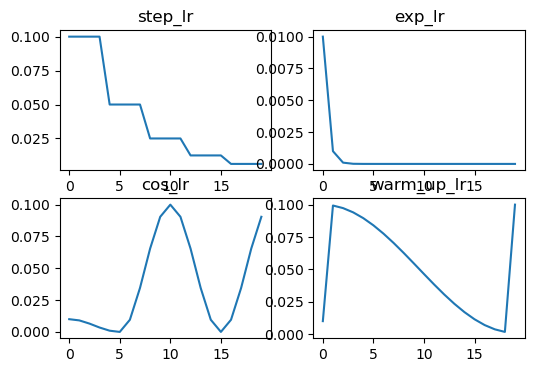

In [80]:
epochs = 20


schedulers = {'step_lr':torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5),
              'exp_lr':torch.optim.lr_scheduler.ExponentialLR(optimizer,  gamma=0.1),              
              'cos_lr':torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0),
              'warm_up_lr':torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                   T_0=19, T_mult=1, 
                                                                   eta_min=0.001)}

lrs = np.zeros((len(schedulers), epochs))
fig, axs = plt.subplots(2,2,figsize=(6,4));

with torch.inference_mode():
     
    for j, (k,scheduler) in enumerate(zip(schedulers.keys(), schedulers.values())):

        for i in range(epochs):
            optimizer.step()
            lrs[j,i] = optimizer.param_groups[0]["lr"]
            scheduler.step()
        optimizer.param_groups[0]["lr"]  = 0.01
        axs.ravel()[j].plot(range(epochs),lrs[j]); 
        axs.ravel()[j].set_title(k);


<blockquote>

Отметим, что также может быть использован планировщик `ReduceLROnPlateau` - который снижает скорость обучения автоматически,  при выходе валидации на плато.
    
```python

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(10):
        train(...)
        val_loss = validate(...)
        # Note that step should be called after validate()
        scheduler.step(val_loss)
```

Дополним функцию тренировки новым аргументом `scheduler`.

In [81]:
def train(model, dataloader, optimizer, criterion, metric, scheduler=None,  device = 'cpu'):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric( y_pred, y)

        loss.backward()
        
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type= 2)
        
        optimizer.step()                

        epoch_loss += loss.item()
        epoch_acc  += acc.item()
    
    if scheduler != None:
        scheduler.step()
        
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

Проверим работы расписания. 

Следует также отметить, что помимо расписания ниже приведен следующий код:
```python
    max_grad = 10
    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))
```

Такой прием позволяет ограничить значение градиента (`gradient clipping`) `lambda grad: torch.clamp(grad, -0.1, max_grad)`. Прием применяется для всех параметров. Так как задан цикл. При этом данный прием записывается как дополнительная функцию при расчете градиента. Это реализована через т.н. `hook`. По средствам метода `register_hook` подобно `callback` каждому параметру ставится дополнительная функция в соотвествие.

> Отметим, что можно бы было провести `gradient clipping` при помощи встроенной утилиты `torch.nn.utils.clip_grad_norm_`. В  функции `train` выше эта строка закомментирована. 

In [82]:
LR_PERIOD = 2
LR_DECAY  = 0.9
LR = 0.1;


model = Model()
model = model.to(device)
criterion = criterion.to(device)

model.apply(initialize_parameters)

max_grad = 10
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -0.1, max_grad))

optimizer = optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
                                            step_size = LR_PERIOD, 
                                            gamma     = LR_DECAY)


In [83]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, scheduler)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 10s | LR 0.1000
	Train Loss: 0.927 | Train Acc: 65.34%  | Val. Loss: 0.828 | Val. Acc: 68.85%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 11s | LR 0.0900
	Train Loss: 0.820 | Train Acc: 69.96%  | Val. Loss: 0.800 | Val. Acc: 70.94%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 11s | LR 0.0900
	Train Loss: 0.810 | Train Acc: 71.26%  | Val. Loss: 0.841 | Val. Acc: 71.66%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 11s | LR 0.0810
	Train Loss: 0.781 | Train Acc: 72.62%  | Val. Loss: 0.785 | Val. Acc: 70.84%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 11s | LR 0.0810
	Train Loss: 0.774 | Train Acc: 72.93%  | Val. Loss: 0.770 | Val. Acc: 71.50%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 11s | LR 0.0729
	Train Loss: 0.807 | Train Acc: 71.21%  | Val. Loss: 0.824 | Val. Acc: 71.16%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 11s | LR 0.0729
	Train Loss: 0.766 | Train Acc: 72.19%  | Val. Loss: 0.812 | Val. Acc: 71.46%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 11s | LR 0.0656
	Train Loss: 0.755 | Train Acc: 72.52%  | Val. Loss: 0.751 | Val. Acc: 73.84%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 11s | LR 0.0656
	Train Loss: 0.746 | Train Acc: 72.64%  | Val. Loss: 0.715 | Val. Acc: 74.43%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 11s | LR 0.0590
	Train Loss: 0.774 | Train Acc: 71.81%  | Val. Loss: 0.866 | Val. Acc: 69.68%


In [84]:
test_loss, test_acc = evaluate(model, test_loader, criterion, metric, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.876 | Test Acc: 69.58%


<!-- https://pytorch.org/vision/main/auto_examples/transforms/plot_cutmix_mixup.html#sphx-glr-auto-examples-transforms-plot-cutmix-mixup-py
from torchvision.transforms import v2
NUM_CLASSES = 10
alpha  = 0.5

cutmix = v2.CutMix(num_classes=NUM_CLASSES, alpha = alpha)
mixup = v2.MixUp(num_classes=NUM_CLASSES, alpha = alpha)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

for images, labels in train_loader:
    images = images.reshape(-1,1,28,28)
    print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }")
    images, labels = cutmix_or_mixup(images, labels)
    print(f"After  CutMix/MixUp: {images.shape = }, {labels.shape = }")
    
    targets1, targets2 = 
    loss = alpha * criterion(preds, targets1) + (1 - self.alpha) * criterion(preds, targets2)

    break
    
targets = torch.nonzero(labels).reshape(-1,4)[:,1::2]
    
images = images.reshape(-1,1,28,28)
batch = torchvision.utils.make_grid(images, nrow = int(np.sqrt(images.shape[0])), padding = 0)
vis_batch = batch.data.numpy().transpose((1, 2, 0))*255
plt.imshow(vis_batch); 
plt.axis('off');
plt.show()
images.shape, batch.shape,  vis_batch.shape  

class CutMixCELoss(nn.Module):
    def __init__(self, alpha = 0.5):
        super(CutMixCELoss, self).__init__() 
        self.criterion = nn.CrossEntropyLoss
        self.alpha = alpha

    def farward(self, preds, targets):
        targets1, targets2  = targets
        return self.alpha * self.criterion(preds, targets1)\
            + (1 - self.alpha) * self.criterion(preds, targets2)
            
```python
    from torch.utils.data import default_collate

    def collate_fn(batch):
        return cutmix_or_mixup(*default_collate(batch))
    
    
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn) -->

## Задания

**1.** Проверьте как виляют те или иные режимы инициализации на качество работы нейронной сети. Например инициализация постанными величинами `nn.init.constant_(m.weight, constant_weight)`.

__2.__ В ряде [случаев](https://discuss.pytorch.org/t/tricks-for-being-able-to-use-a-higher-learning-rate/142179) рекомендуется стратегия обучения, когда изначально используется крайне низкая скорость обучения в течение нескольких эпох чтобы веса модели настроились в нужном направлении. Такие эпохи будут сравнительно бесполезными с точки зрения результата обучения, но повышают стабильность экспериментов.   Затем скорость обучения резко увеличивают и начинают плавно снижать. Предполагается что после превоначальной настройки весов они могут быстро обучиться в нужном направлении. __Предлагается__ реализовать эту стратегию самостоятельно.

__3.__ В ряде [работ](https://openreview.net/pdf?id=B1Yy1BxCZ) рекомендуется вместе с изменением скорости обучения (с ее снижением) [увеличивать размер батча](https://stackoverflow.com/questions/53033556/how-should-the-learning-rate-change-as-the-batch-size-change). __Предлагается__ реализовать эту стратегию обучения самостоятельно. 

> [Иногда](https://ar5iv.labs.arxiv.org/abs/1803.09820) также рекомендуют уменьшать затухание весов  с ростом эпохи обучения (параметр `L2` регуляризации - `weight_decay` в оптимизиаторах). Если используется параметр `momentum`, то он должен снижаться с увеличением скорости обучения [или циркулировать](https://ar5iv.labs.arxiv.org/abs/1803.09820).

__4.__ Настройка параметров обучения может быть выполнена не только по блокам модели, но и по отедельм параметрам. Например, если используется `SGD with weight_decay` иногда полезно отключить `weight_decay` для  параметра смещения. Это можно сделать следующим образом.
    
```python
    bias_params = [p for name, p in self.named_parameters() if 'bias' in name]
    others = [p for name, p in self.named_parameters() if 'bias' not in name]

    optim.SGD([
                    {'params': others},
                    {'params': bias_params, 'weight_decay': 0}
                ], weight_decay=1e-2, lr=1e-2)
```
> Отметим, что также [в ряде случаев](https://github.com/NVIDIA/DeepLearningExamples/blob/8d8b21a933fff3defb692e0527fca15532da5dc6/PyTorch/Classification/ConvNets/image_classification/training.py)  'weight_decay' не используется для параметров батч-нормализации.

__Предлагается__ проверить качество такого оптимизатора самостоятельно.

__5.__ Иногда в функцию потерь также добавляют параметр [`label_smoothing`](https://paperswithcode.com/method/label-smoothing),  выставляя его небольшим. При этом итоговая метка класса формируется как $$ y_s = (1-\eta y) + U[0, \eta/K]$$, где $\eta$- весовой коффициент, $K$ число классов, а $ U[0, \eta/K]$ равномерное распределение. То есть $y_s$ представляет собой вектор где основной класс имеет значение в диапзоне $(0,1)$, а остаток этого диапазона "размыт" между значениями остальных классов. В таком случае ожидается, что подразумеваемая функция активации $softmax$ не будет выходить в насыщение, что снизит вероятность переобучения слоя принятия решений. Сегодня `label_smoothing` в оригинальной функции потерь, как это показано ниже. __Предлагается__ попробывать использовать эту функцию самостоятельно.

```python 
    nn.CrossEntropyLoss(label_smoothing = ...)
```

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html

# Различные способы отслеживания экспериментов по машинному обучению 

В рассмотренных примерах  отслеживание хода обучения модели проводилось  с помощью имеющихся инструментов `Python`  (это были списки, в более продвинутых экспериментах полезно бы было использование словарей, `Pandas DataFrames` или логирование результатов, например в `csv` файлы). Однако, если экспериментов становится слишьком много, то такой подход может помешать точному логированию результатов. Поэтому в проектах, требующих достаточного большого числа испытаний используются специализированные инструменты.  

Существует ряд утилит для отслеживания экспериментов по машинному обучению. В  таблице описаны некоторые из них.

| **Метод** | **Установка** | **Плюсы** | **Контакты** | **Стоимость** |
| ----- | ----- | ----- | ----- | ----- |
| Словари, списки Python, CSV-файлы, Pandas DataFrames | Нет | Легко настраивается, работает на чистом Python | Трудно отслеживать большое количество экспериментов | Бесплатно |
| [TensorBoard](https://www.tensorflow.org/tensorboard/get_started) | Минимально, установите [`tensorboard`](https://pypi.org/project/tensorboard/) | Расширения, встроенные в PyTorch, широко известны и используются, легко масштабируются. | Пользовательский опыт не так приятен, как у других вариантов. | Бесплатно |
| [Weights & Biases Experiment Tracking](https://wandb.ai/site/experiment-tracking) | Минимально, установите [`wandb`](https://docs.wandb.ai/quickstart), заведите аккаунт | Невероятный пользовательский опыт, делает эксперименты публичными, отслеживает практически все. | Требуется внешний ресурс за пределами PyTorch. | Бесплатно для личного использования | 
| [MLFlow](https://mlflow.org/) | Минимально, установите `mlflow` и начинайте отслеживать | Полностью открытое управление жизненным циклом MLOps, много интеграций. | Немного сложнее настроить удаленный сервер отслеживания, чем в других сервисах. | Бесплатно | 

<!-- <img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/07-different-places-to-track-experiments.png" alt="различные места для отслеживания экспериментов по машинному обучению" width=900/> -->

Рассмотрим утилиту [`TensorBoard`](https://www.tensorflow.org/tensorboard/get_started). Утилита `TensorBoard` является частью библиотеки глубокого обучения `TensorFlow` и представляет собой отличный способ визуализации различных частей вашей модели.


Для работы с `TensorBoard` в  `PyTorch`  можно использовать класс [`torch.utils.tensorboard.SummaryWriter()`](https://pytorch.org/docs/stable/tensorboard.html). Объект позволяет сохранять различные частей прогресса обучения  модели в файл.

Перед работой с`SummaryWriter()` необходимо установить `TensorBoard`. Установка может быть произведена при помощи команды ```pip install tensorboard```.

По умолчанию класс `SummaryWriter()` сохраняет различную информацию о модели в файл, заданный параметром `log_dir`. 
По умолчанию `log_dir` находится в папке `runs/CURRENT_DATETIME_HOSTNAME`, где `HOSTNAME` - это имя компьютера. Bмя файла можно настроить по своему усмотрению.

Результаты работы `SummaryWriter()` сохраняются в формате [`TensorBoard`](https://www.tensorflow.org/tensorboard/).


Также для того, чтобы запустить `TensorBoard` в jupyter notebook необходимо указать директиву `%load_ext tensorboard`


In [85]:
# !pip install tensorboard

In [86]:
%reload_ext tensorboard

Создадим объект `writer` класса `SummaryWriter` c указанием пути записи логов в `log_dir`.

In [87]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter(log_dir="D://run")


4В наиболее простом случае среди всего функционала `SummaryWriter` потребуется метод `add_scalar`. Метод будет вызван для 4 переменных обучения с указанием метки, например `"Metric/valid"`, необходимого значения и номера эпохи обучения.

Также желательно указывать `writer.flush()` после окончания сессии. Если объект больше не понадобиться, то можно также указать `writer.close()`.

https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/07_pytorch_experiment_tracking.ipynb#scrollTo=nD3IsXY_ngmx

In [88]:
EPOCHS = 14

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, scheduler)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
    f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    
#     writer.add_scalar("Loss/train", train_loss, epoch)
#     writer.add_scalar("Loss/valid", valid_loss, epoch)
#     writer.add_scalar("Metric/train", train_acc, epoch)
#     writer.add_scalar("Metric/valid", valid_acc, epoch)    
    
# writer.flush()
    writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
    writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
    writer.add_graph(model=model, 
                         input_to_model=torch.randn(BATCH_SIZE,  28 * 28).to(device))
    
    # Close the writer
    writer.close()

  0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 12s | LR 0.0590
	Train Loss: 0.789 | Train Acc: 70.96%  | Val. Loss: 0.824 | Val. Acc: 70.48%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 11s | LR 0.0531
	Train Loss: 0.750 | Train Acc: 72.84%  | Val. Loss: 0.725 | Val. Acc: 74.89%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 11s | LR 0.0531
	Train Loss: 0.718 | Train Acc: 73.81%  | Val. Loss: 0.707 | Val. Acc: 74.20%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 11s | LR 0.0478
	Train Loss: 0.709 | Train Acc: 74.41%  | Val. Loss: 0.700 | Val. Acc: 76.19%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 11s | LR 0.0478
	Train Loss: 0.725 | Train Acc: 74.05%  | Val. Loss: 0.778 | Val. Acc: 73.10%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 12s | LR 0.0430
	Train Loss: 0.720 | Train Acc: 74.77%  | Val. Loss: 0.664 | Val. Acc: 76.16%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 11s | LR 0.0430
	Train Loss: 0.695 | Train Acc: 75.31%  | Val. Loss: 0.749 | Val. Acc: 74.74%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 11s | LR 0.0387
	Train Loss: 0.686 | Train Acc: 75.51%  | Val. Loss: 0.684 | Val. Acc: 74.92%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 12s | LR 0.0387
	Train Loss: 0.665 | Train Acc: 76.00%  | Val. Loss: 0.681 | Val. Acc: 75.47%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 12s | LR 0.0349
	Train Loss: 0.650 | Train Acc: 76.53%  | Val. Loss: 0.650 | Val. Acc: 77.35%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 11s | LR 0.0349
	Train Loss: 0.617 | Train Acc: 77.81%  | Val. Loss: 0.653 | Val. Acc: 76.90%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 11s | LR 0.0314
	Train Loss: 0.607 | Train Acc: 78.27%  | Val. Loss: 0.605 | Val. Acc: 78.63%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 11s | LR 0.0314
	Train Loss: 0.592 | Train Acc: 78.86%  | Val. Loss: 0.607 | Val. Acc: 78.70%


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 11s | LR 0.0282
	Train Loss: 0.575 | Train Acc: 79.96%  | Val. Loss: 0.548 | Val. Acc: 80.97%


In [89]:
%tensorboard --logdir D:\\run --port 6015

Reusing TensorBoard on port 6015 (pid 16812), started 16:11:44 ago. (Use '!kill 16812' to kill it.)

## 5. View our model's results in TensorBoard

The `SummaryWriter()` class stores our model's results in a directory called `runs/` in TensorBoard format by default.

TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data.

You know what that means?

It's time to follow the data visualizer's motto and *visualize, visualize, visualize!* 

You can view TensorBoard in a number of ways:

| Code environment | How to view TensorBoard | Resource |
| ----- | ----- | ----- |
| VS Code (notebooks or Python scripts) | Press `SHIFT + CMD + P` to open the Command Palette and search for the command "Python: Launch TensorBoard". | [VS Code Guide on TensorBoard and PyTorch](https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration) |
| Jupyter and Colab Notebooks | Make sure [TensorBoard is installed](https://pypi.org/project/tensorboard/), load it with `%load_ext tensorboard` and then view your results with `%tensorboard --logdir DIR_WITH_LOGS`. | [`torch.utils.tensorboard`](https://pytorch.org/docs/stable/tensorboard.html) and [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started) |

You can also upload your experiments to [tensorboard.dev](https://tensorboard.dev/) to share them publicly with others.

Running the following code in a Google Colab or Jupyter Notebook will start an interactive TensorBoard session to view TensorBoard files in the `runs/` directory.

```python
%load_ext tensorboard # line magic to load TensorBoard
%tensorboard --logdir runs # run TensorBoard session with the "runs/" directory
```

https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/07_pytorch_experiment_tracking.ipynb#scrollTo=nD3IsXY_ngmx


https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks?hl=ru

In [90]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6013: logdir D:run (started 16:12:43 ago; pid 10064)
  - port 6009: logdir D:\run (started 16:16:43 ago; pid 13268)
  - port 6008: logdir D:/ (started 16:29:36 ago; pid 14412)
  - port 6015: logdir D:\run (started 16:11:44 ago; pid 16812)
  - port 6007: logdir logs (started 16:34:04 ago; pid 20292)
  - port 6006: logdir runs (started 1 day, 15:06:59 ago; pid 20308)
  - port 6006: logdir runs (started 1 day, 15:06:03 ago; pid 20784)
  - port 6007: logdir runs (started 1 day, 14:58:13 ago; pid 22072)
  - port 6007: logdir runs (started 1 day, 15:01:51 ago; pid 22416)
  - port 6006: logdir ./lightning_logs (started 16:43:25 ago; pid 5168)
  - port 6010: logdir D:run (started 16:14:04 ago; pid 7128)


In [91]:
notebook.display(port=6015, height=1000)


Selecting TensorBoard with logdir D:\run (started 16:11:44 ago; port 6015, pid 16812).


In [92]:
writer.close()

https://github.com/ritchieng/the-incredible-pytorch

https://github.com/pytorch/captum

https://sebastianraschka.com/blog/2023/pytorch-faster.html

In [93]:
def train(num_epochs, model, optimizer, train_loader, val_loader, device):
    for epoch in range(num_epochs):
        train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)

        for batch_idx, batch in enumerate(train_loader):
            model.train()
            for s in ["input_ids", "attention_mask", "label"]:
                batch[s] = batch[s].to(device)

            ### FORWARD AND BACK PROP
            outputs = model(
                batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["label"],
            )
            
            
            optimizer.zero_grad()
            outputs["loss"].backward()

            ### UPDATE MODEL PARAMETERS
            optimizer.step()

            ### LOGGING
            if not batch_idx % 300:
                print(
                    f"Epoch: {epoch+1:04d}/{num_epochs:04d} | Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {outputs['loss']:.4f}"
                )

            model.eval()
            with torch.no_grad():
                predicted_labels = torch.argmax(outputs["logits"], 1)
                train_acc.update(predicted_labels, batch["label"])

        ### MORE LOGGING
        with torch.no_grad():
            model.eval()
            val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2).to(device)
            for batch in val_loader:
                for s in ["input_ids", "attention_mask", "label"]:
                    batch[s] = batch[s].to(device)
                outputs = model(
                    batch["input_ids"],
                    attention_mask=batch["attention_mask"],
                    labels=batch["label"],
                )
                predicted_labels = torch.argmax(outputs["logits"], 1)
                val_acc.update(predicted_labels, batch["label"])

            print(
                f"Epoch: {epoch+1:04d}/{num_epochs:04d} | Train acc.: {train_acc.compute()*100:.2f}% | Val acc.: {val_acc.compute()*100:.2f}%"
            )